In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from tensorflow.keras import layers

# Nomor 2a

karena mengalami kendala saat download data dari github, saya load data Fashion MNIST via library tensorflow. setelah melakukan pengecekan, datasetnya sama persis.

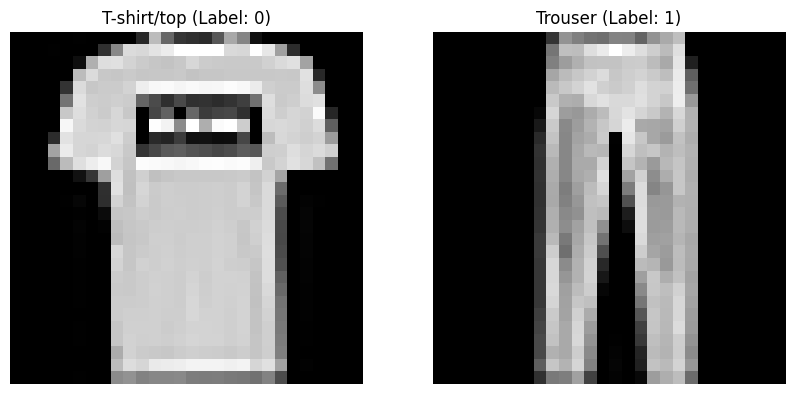

In [23]:
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()

tshirt_top_index = np.where(y_train_full == 0)[0][0]  
trouser_index = np.where(y_train_full == 1)[0][0] 

tshirt_top_image = x_train_full[tshirt_top_index]
trouser_image = x_train_full[trouser_index]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(tshirt_top_image, cmap='gray')
plt.title('T-shirt/top (Label: 0)')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(trouser_image, cmap='gray')
plt.title('Trouser (Label: 1)')
plt.axis('off')

plt.show()

Setelah itu, saya melakukan splitting dataset menjadi 80% train, 10% val, dan 10% sisanya menjadi data test.

In [24]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_all = np.concatenate([x_train, x_test])
y_all = np.concatenate([y_train, y_test])

mask = np.isin(y_all, [0, 1])
x_filtered = x_all[mask]
y_filtered = y_all[mask]

x_filtered = x_filtered.astype('float32') / 255.
x_filtered = x_filtered.reshape((-1, 28, 28, 1))

x_train_val, x_test, y_train_val, y_test = train_test_split(x_filtered, y_filtered, test_size=0.1, stratify=y_filtered, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.1111, stratify=y_train_val, random_state=42)

print(f"Training set shape: {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (11200, 28, 28, 1)
Validation set shape: (1400, 28, 28, 1)
Test set shape: (1400, 28, 28, 1)


# Nomor 2b


Pertama, encoder mengambil input gambar berukuran 28x28 piksel dengan saluran warna tunggal (grayscale). Proses encoding dimulai dengan lapisan Conv2D yang memiliki 32 filter dengan ukuran kernel 3x3 dan aktivasi ReLU, yang diikuti oleh lapisan MaxPooling2D untuk mengurangi dimensi gambar dengan faktor 2. Hasil dari lapisan ini kemudian dilunakkan (flatten) ke dalam vektor satu dimensi. Vektor ini kemudian dimampatkan (encoded) ke dalam ruang fitur yang lebih rendah dengan lapisan Dense yang memiliki 128 neuron dengan aktivasi ReLU.

Kedua, decoder mengambil vektor hasil dari encoder sebagai input. Proses decoding dimulai dengan lapisan Dense yang mentransformasi vektor ke dimensi yang lebih tinggi (6272), diikuti oleh lapisan Reshape untuk mengembalikan vektor ke bentuk yang sesuai dengan dimensi gambar setelah MaxPooling2D (14x14 dengan 32 channel). Lalu, gambar di-upsample kembali dengan faktor 2 menggunakan lapisan UpSampling2D untuk meningkatkan dimensi gambar. Setelah itu, dilakukan lapisan Conv2D dengan 32 filter 3x3 dan aktivasi ReLU, diikuti oleh lapisan Conv2D terakhir dengan 1 filter 3x3 dan aktivasi sigmoid untuk menghasilkan output yang berupa rekonstruksi gambar yang memiliki saluran warna tunggal (grayscale).

Kombinasi dari encoder dan decoder ini membentuk autoencoder yang dapat melakukan kompresi dan rekonstruksi gambar dengan tujuan untuk mempelajari representasi yang lebih ringkas dari data input. Model ini di-training menggunakan optimizer Adam dengan fungsi loss binary_crossentropy untuk meminimalkan kesalahan rekonstruksi antara input dan output.

In [25]:
def create_autoencoder():
    # Encoder
    encoder_input = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    encoded = layers.Dense(128, activation='relu')(x)
    # Decoder
    x = layers.Dense(6272, activation='relu')(encoded)
    x = layers.Reshape((14, 14, 32))(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    # Model Autoencoder
    autoencoder = models.Model(encoder_input, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

model = create_autoencoder()
model.summary()

Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,621,889 (6.19 MB)

 Trainable params: 1,621,889 (6.19 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer='adam', loss='binary_crossentropy')

model.fit(x_train, x_train,
                epochs=50,
                batch_size=128, callbacks=[early_stopping],
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/50
19/88 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5870

W0000 00:00:1720361017.176162     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720361017.178255     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4402

W0000 00:00:1720361018.587159     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720361018.589159     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720361019.046995     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.4393 - val_loss: 0.2887
Epoch 2/50
29/88 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2845

W0000 00:00:1720361019.285117     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2814 - val_loss: 0.2680
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2670 - val_loss: 0.2598
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2617 - val_loss: 0.2551
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2534 - val_loss: 0.2525
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2527 - val_loss: 0.2508
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2501 - val_loss: 0.2496
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2492 - val_loss: 0.2487
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2476 - val_loss: 0.2476
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2469 - val_loss: 0.2469
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2466 - val_loss: 0.2464
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2449 - val_loss: 0.2457
Epoch 13/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2450 - val_loss: 0.2453

38/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   

W0000 00:00:1720361047.727249     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


W0000 00:00:1720361048.062091     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Average SSIM score on test set: 0.8957635562280676


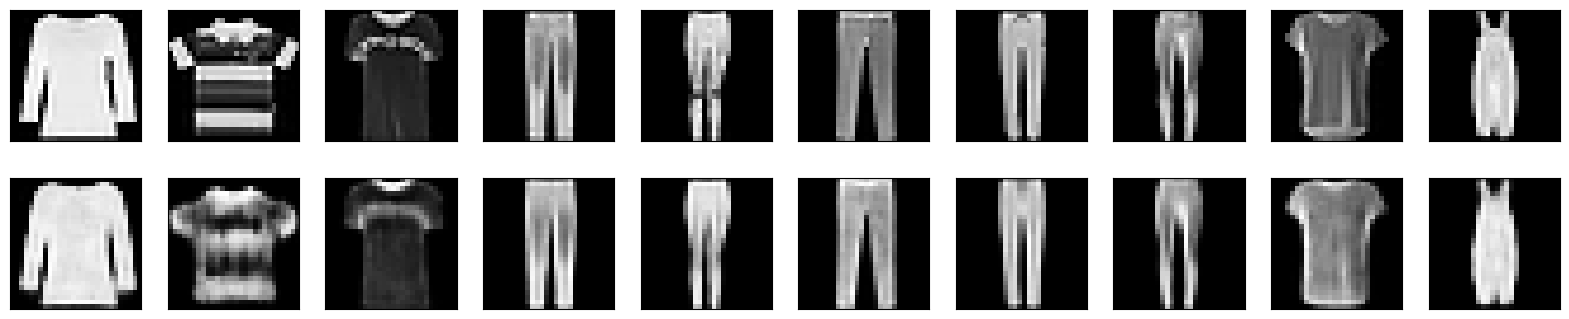

In [27]:
def calculate_ssim(original, reconstructed):
    ssim_scores = []
    for orig, recon in zip(original, reconstructed):
        ssim_scores.append(ssim(orig.squeeze(), recon.squeeze(), data_range=1.0))
    return np.mean(ssim_scores)

reconstructed_images = model.predict(x_test)

ssim_score = calculate_ssim(x_test, reconstructed_images)
print(f"Average SSIM score on test set: {ssim_score}")

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Nomor 2c


Dengan melihat model baseline sudah memiliki performa yang sangat baik, saya mengalami kesulitan dalam membuat model yang lebih baik dari model baseline berndasakran Average SSIM nya. akan tetapi saya mencoba menggunakan model yang lebih kompleks dan ternyata menghasilkan performa SSIM score yang sedikit lebih baik.

In [34]:
def build_model():
    conv_1_units = 128
    conv_2_units = 256
    dense_units = 512
    latent_dim = 256
    learning_rate = 1e-5

    encoder = keras.Sequential()
    encoder.add(layers.Conv2D(conv_1_units, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.Conv2D(conv_1_units, (3, 3), activation='relu', padding='same'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.MaxPooling2D((2, 2), padding='same'))
    
    encoder.add(layers.Conv2D(conv_2_units, (3, 3), activation='relu', padding='same'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.Conv2D(conv_2_units, (3, 3), activation='relu', padding='same'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.MaxPooling2D((2, 2), padding='same'))
    
    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(dense_units, activation='relu'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.Dense(latent_dim, activation='relu', name='latent'))

    flatten_shape = 7 * 7 * conv_2_units

    decoder = keras.Sequential()
    decoder.add(layers.Dense(flatten_shape, activation='relu', input_shape=(latent_dim,)))
    decoder.add(layers.Reshape((7, 7, conv_2_units)))
    
    decoder.add(layers.Conv2DTranspose(conv_2_units, (3, 3), strides=2, activation='relu', padding='same'))
    decoder.add(layers.BatchNormalization())
    
    decoder.add(layers.Conv2DTranspose(conv_1_units, (3, 3), strides=2, activation='relu', padding='same'))
    decoder.add(layers.BatchNormalization())
    
    decoder.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

    autoencoder = keras.Sequential([encoder, decoder])
    autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate),
                        loss='mean_squared_error')  # Use mean_squared_error for reconstruction loss
    return autoencoder

best_model = build_model()
best_model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)      │ ?                      │     7,593,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_13 (Sequential)      │ ?                      │     4,111,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,705,217 (44.65 MB)

 Trainable params: 11,701,889 (44.64 MB)

 Non-trainable params: 3,328 (13.00 KB)

In [35]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

best_model.compile(optimizer='adam', loss='binary_crossentropy')

best_model.fit(x_train, x_train,
                epochs=50,
                batch_size=128, callbacks=[early_stopping],
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/50
 2/88 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - loss: 1.0354 

W0000 00:00:1720361410.173738     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720361410.176548     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.4590

W0000 00:00:1720361419.009541     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720361419.012394     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720361419.870735     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - loss: 0.4576 - val_loss: 0.5062
Epoch 2/50


W0000 00:00:1720361420.593986     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.2655 - val_loss: 0.4658
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.2576 - val_loss: 0.4398
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.2544 - val_loss: 0.4065
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.2504 - val_loss: 0.3621
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.2501 - val_loss: 0.2937
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.2465 - val_loss: 0.2630
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.2466 - val_loss: 0.2552
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.2469 - val_loss: 0.2454
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.2443 - val_loss: 0.2442
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.2440 - val_loss: 0.2444
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.2443 - val_loss: 0.2515
Epoch 13/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.2426 - val_

27/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

W0000 00:00:1720361625.414417     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


W0000 00:00:1720361626.230552     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Average SSIM score on test set: 0.8981199071173036


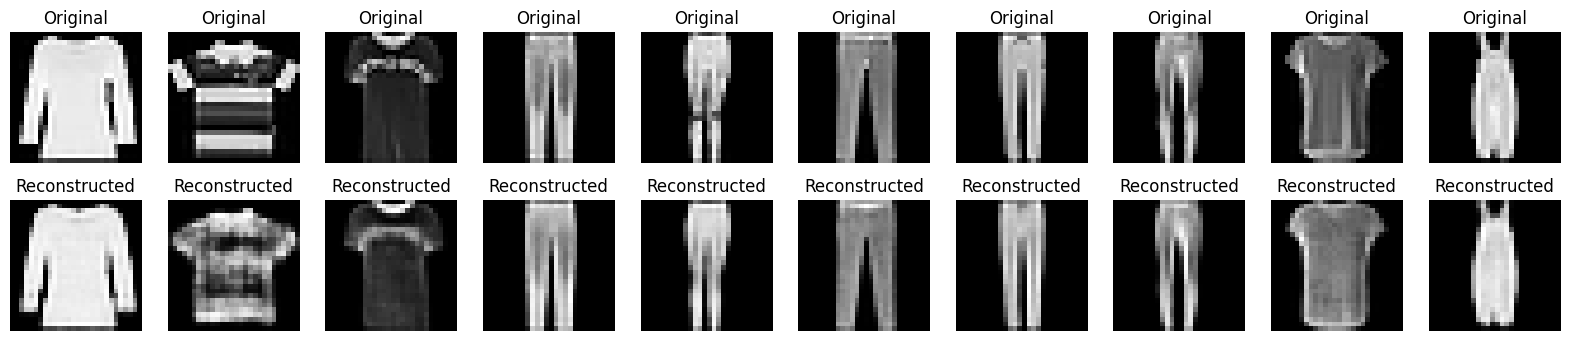

In [36]:
reconstructed_images = best_model.predict(x_test)
ssim_score = calculate_ssim(x_test, reconstructed_images)
print(f"Average SSIM score on test set: {ssim_score}")

def plot_reconstructed_images(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

plot_reconstructed_images(x_test, reconstructed_images)

Arsitektur Encoder: 

Model yang dimodifikasi memiliki lapisan Conv2D dengan jumlah filter yang lebih besar (128 dan 256), yang dapat membantu dalam mengekstraksi fitur yang lebih kompleks dari dataset Fashion MNIST yang memiliki variasi yang lebih besar dalam kelas gambar.


Arsitektur Decoder: 

Penggunaan Conv2DTranspose untuk membalikkan operasi Conv2D memungkinkan model untuk menghasilkan rekonstruksi gambar yang lebih jelas dan dekat dengan aslinya.


Optimasi dan Evaluasi: 

Pengaturan learning rate yang lebih rendah dan penggunaan mean_squared_error dalam model modifikasi dapat membantu dalam menghasilkan rekonstruksi gambar yang lebih baik dengan SSIM yang sedikit lebih tinggi.
Performa: Penambahan filter dan optimasi parameter pada model modifikasi tampaknya memberikan sedikit peningkatan dalam kemampuan model untuk melakukan rekonstruksi yang lebih baik, seperti yang tercermin dalam nilai SSIM yang lebih tinggi.